In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

from skimage import feature

from astropy import units as u
from astropy.table import Table, vstack
from astropy.io import ascii, fits
from astropy.modeling import models, fitting, custom_model

In [2]:
file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0373.fits"
center = ascii.read("/Users/tim/MMT/shwfs/mmirs2_reference.center")
ref = ascii.read("/Users/tim/MMT/shwfs/mmirs2_sysfile.cntr")

In [3]:
im = fits.open(file)[0].data
edges = feature.canny(im, sigma=10)

<IPython.core.display.Javascript object>


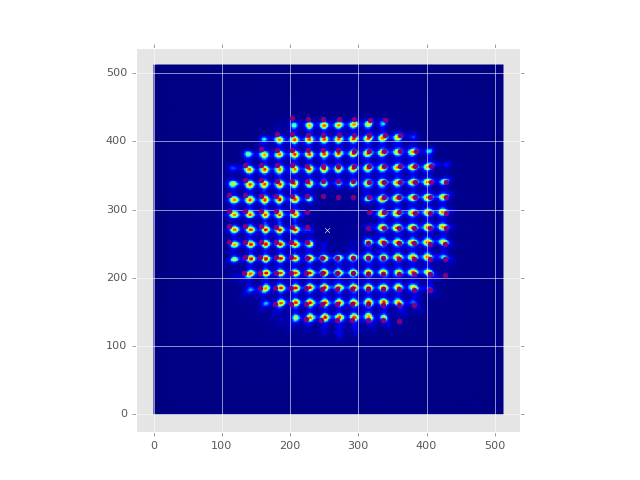

In [4]:
plt.imshow(np.flipud(im), interpolation='nearest', origin='lower')
plt.scatter(ref['col1'], ref['col2'], color='purple')
plt.scatter(center['col1'], center['col2'], marker='x', color='white')
#plt.scatter(256, 256, marker='x', color='white')
plt.show()

<IPython.core.display.Javascript object>


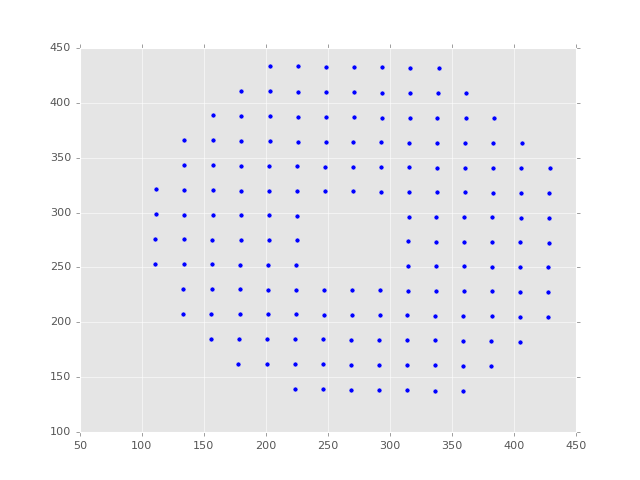

In [18]:
plt.scatter(ref['col1'], ref['col2'])
plt.show()

In [44]:
plt.scatter?